In [1]:
import numpy as np
from sklearn import linear_model
import pickle
import matplotlib.pyplot as plt
import itertools

### Experiments(Discrete Features)

X_1,X_2 are related dependent variables

#### Submodularity Test
$f(X \cup \{x\})-f(X)\geq f(Y \cup \{x\})-f(Y)\quad \text{if } X\subseteq Y\quad x\in \Omega \setminus Y$

In [2]:
# fit linear regression with given features 
def lr(features,train_X,train_y,test_X,test_y):
    features = np.array(list(features))
    n_feature =len(features)
    train_err = 0.0
    test_err = 0.0
    train_vector =np.sum(train_X[:,features]* np.array([2**i for i in range(n_feature)]),axis=1)
    test_vector =np.sum(test_X[:,features]* np.array([2**i for i in range(n_feature)]),axis=1)
    for v in range(2**n_feature):
        train_idx = np.where(train_vector==v)[0]
        test_idx = np.where(test_vector==v)[0]
        train_err += np.sum((np.mean(train_y[train_idx])-train_y[train_idx])**2)
        if len(test_idx)!=0:
            test_err += np.sum((np.mean(test_y[test_idx])-test_y[test_idx])**2)
    return train_err/len(train_y),test_err/len(test_y)

In [4]:
# Data generation
# Xi ~ Ber(n,pi)

# probs = np.array([0.5,0.4,0.6,0.4,0.7,0.3])
probs = np.array([0.5, 0.4, 0.6, 0.4])
n = 10**3
s = 0
f = 0
for i,k in enumerate(itertools.product([0,1],repeat=len(probs))):
    l = np.prod(probs**np.array(k))*np.prod((1-probs)**(1-np.array(k)))*n+1e-6
    f+=l
    l = int(l)
    s+=l
    if i==0:X = np.tile(np.array(k),(l,1))
    else:X = np.vstack([X,np.tile(np.array(k),(l,1))])

print X.shape
X = X[np.random.permutation(n)]
# probs = [0.4,0.6,0.4,0.6,0.4,0.6]
# n = 1000
# X = np.zeros((n,6))
# for i,p in enumerate(probs):
#     X[:,i]=np.array([np.random.binomial(1,p) for j in range(n)])
n = 200
test_X = np.zeros((n,4))
for i,p in enumerate(probs):
    test_X[:,i]=np.array([np.random.binomial(1,p) for j in range(n)])
    
beta = np.random.randn(4,2)*2
y = np.zeros(1000)
for i in range(1000):
    if X[i][0]==0:
        if X[i][1]==0: y[i] = sum(beta[0][:2]*X[i][:2])+beta[0][1]
        else: y[i] = sum(beta[1][:2]*X[i][:2])+beta[1][1]
    else:
        if X[i][1]==0: y[i] = sum(beta[2][:2]*X[i][:2])+beta[2][1]
        else: y[i] = sum(beta[3][:2]**X[i][:2])+beta[3][1]
test_y = np.zeros(n)
for i in range(n):
    if test_X[i][0]==0:
        if test_X[i][1]==0: test_y[i] = sum(beta[0][:2]*test_X[i][:2])+beta[0][1]
        else: test_y[i] = sum(beta[1][:2]*test_X[i][:2])+beta[1][1]
    else:
        if test_X[i][1]==0: test_y[i] = sum(beta[2][:2]*test_X[i][:2])+beta[2][1]
        else: test_y[i] = sum(beta[3][:2]**test_X[i][:2])+beta[3][1]
# add noise e~N(0,0.5^2)
y = y+np.random.randn(1000)*0.5
test_y += np.random.randn(200)*0.5
train_X = X#[:int(n*0.8)]
train_y = y#[:int(n*0.8)]
print len(train_y)

(1000, 4)
1000


In [5]:
violation = False
v = 0
dr1 = []
dr2 = []
for i in range(2):
    s_y = list(itertools.combinations(np.arange(4),i+2))
    for s in s_y:
        s_x = list(itertools.combinations(s,i+1))
        comp = set(np.arange(4)).difference(set(s))
        for sub_s_x in s_x:
            for c in comp:
                s = set(s)
                sub_s_x = set(sub_s_x )
                print 'X = {}; Y={}; x = {}'.format(sub_s_x,s,c)
                train_err1 = lr(s,train_X,train_y,test_X,test_y)[0]
                train_err2 = lr(sub_s_x,train_X,train_y,test_X,test_y)[0]
                s.add(c)
                sub_s_x.add(c)
                print train_err1 - lr(s,train_X,train_y,test_X,test_y)[0],\
                  train_err2 - lr(sub_s_x,train_X,train_y,test_X,test_y)[0]
                dr1.append(train_err1 - lr(s,train_X,train_y,test_X,test_y)[0])
                dr2.append(train_err2- lr(sub_s_x,train_X,train_y,test_X,test_y)[0])
                if train_err1 - lr(s,train_X,train_y,test_X,test_y)[0]<train_err2 - lr(sub_s_x,train_X,train_y,test_X,test_y)[0]:
                    violation = True
                    if violation: v+=1
                s.remove(c)
                sub_s_x.remove(c)
print violation,v

X = set([0]); Y=set([0, 1]); x = 2
0.00201967090408 0.00026512583197
X = set([0]); Y=set([0, 1]); x = 3
0.00144747062621 0.000140613642598
X = set([1]); Y=set([0, 1]); x = 2
0.00201967090408 0.000799488415334
X = set([1]); Y=set([0, 1]); x = 3
0.00144747062621 0.00137537379438
X = set([0]); Y=set([0, 2]); x = 1
0.901770577099 0.900016032027
X = set([0]); Y=set([0, 2]); x = 3
0.000577468932023 0.000140613642598
X = set([2]); Y=set([0, 2]); x = 1
0.901770577099 0.853576476076
X = set([2]); Y=set([0, 2]); x = 3
0.000577468932023 0.000119944073606
X = set([0]); Y=set([0, 3]); x = 1
0.90132288901 0.900016032027
X = set([0]); Y=set([0, 3]); x = 2
0.000701981121395 0.00026512583197
X = set([3]); Y=set([0, 3]); x = 1
0.90132288901 0.854139608639
X = set([3]); Y=set([0, 3]); x = 2
0.000701981121395 0.000107191258216
X = set([1]); Y=set([1, 2]); x = 0
3.50754389129 3.5063237088
X = set([1]); Y=set([1, 2]); x = 3
0.00146779987063 0.00137537379438
X = set([2]); Y=set([1, 2]); x = 0
3.50754389129 3

#### Greedy Algorithm

In [6]:
# Data generation
# Xi ~ Ber(n,pi)
probs = np.array([0.5, 0.4, 0.6, 0.4])
n = 1000
X = np.zeros((n,4))
for i,p in enumerate(probs):
    X[:,i]=np.array([np.random.binomial(1,p) for j in range(n)])
beta = np.random.randn(4,2)*2
y = np.zeros(n)
for i in range(n):
    if X[i][0]==0:
        if X[i][1]==0: y[i] = sum(beta[0][:2]*X[i][:2])+beta[0][1]
        else: y[i] = sum(beta[1][:2]*X[i][:2])+beta[1][1]
    else:
        if X[i][1]==0: y[i] = sum(beta[2][:2]*X[i][:2])+beta[2][1]
        else: y[i] = sum(beta[3][:2]**X[i][:2])+beta[3][1]
# add noise e~N(0,0.5^2)
y = y+np.random.randn(n)*0.5
train_X = X[:int(n*0.8)]
test_X = X[int(n*0.8):]
train_y = y[:int(n*0.8)]
test_y = y[int(n*0.8):]

0.229267170563 0.247199957015
[  3.42414062e+00   4.15204320e+00   3.03205448e-03   1.34950305e-03]


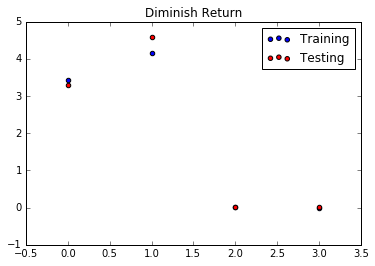

In [7]:
train_r = np.zeros(4)
test_r = np.zeros(4)
feature_set = set(np.arange(4))
train_err,test_err=lr(feature_set,train_X,train_y,test_X,test_y)
print train_err,test_err
for i,s in enumerate(feature_set):
    feature_set.remove(s)
    train_err1,test_err1=lr(feature_set,train_X,train_y,test_X,test_y)
    train_r[i] = train_err1-train_err
    test_r[i] = test_err1-test_err
    feature_set.add(s)
print train_r
plt.scatter(np.arange(4),train_r,label='Training')
plt.scatter(np.arange(4),test_r,label = 'Testing',c = 'red')
plt.title('Diminish Return')
plt.legend()
plt.show()

#### Remove feature according to the diminish return

0.229267170563 0.247199957015


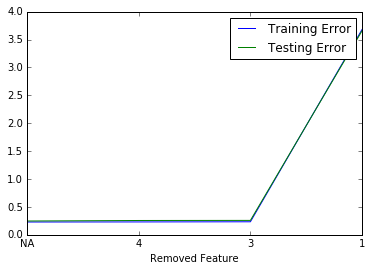

In [8]:
rm_order = np.argsort(train_r)
lr_train_err = np.zeros(4)
lr_test_err = np.zeros(4)
feature_set = set(np.arange(4))
train_err,test_err=lr(feature_set,train_X,train_y,test_X,test_y)
print train_err,test_err
lr_train_err[0] = train_err
lr_test_err[0] = test_err
for i,s in enumerate(rm_order[:-1]):
    feature_set.remove(s)
    train_err,test_err=lr(feature_set,train_X,train_y,test_X,test_y)
    lr_train_err[i+1] = train_err 
    lr_test_err[i+1] = test_err
plt.plot(np.arange(4),lr_train_err,label='Training Error')
plt.plot(np.arange(4),lr_test_err,label = 'Testing Error')
plt.xticks(np.arange(4),np.hstack(['NA',rm_order+1]))
plt.xlabel('Removed Feature')
plt.legend()
plt.show()

0.229267170563 0.247199957015
0.229267170563 0.247199957015
set([1, 2, 3]) 3.65340779528 3.54991137773
set([0, 2, 3]) 4.38131036753 4.82438034476
set([0, 1, 3]) 0.232299225039 0.253752384837
set([0, 1, 2]) 0.230616673609 0.256498356962
set([1, 2]) 3.67376895976 3.62807733072
set([0, 2]) 4.38974662574 4.84755396604
set([0, 1]) 0.233343570698 0.258194405302
set([1]) 3.67821320041 3.65409221262
set([0]) 4.40911421905 4.84810407004
[  1.34950305e-03   2.72689709e-03   3.44486963e+00] [ 3.  2.  0.]


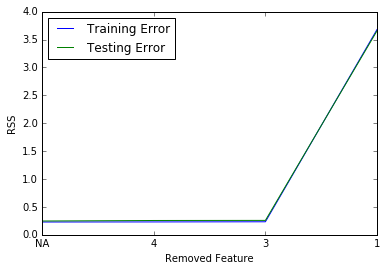

In [9]:
train_r = np.zeros(4)
test_r = np.zeros(4)
r = np.zeros(3)
feature_set = set(np.arange(4))
train_err,test_err=lr(feature_set,train_X,train_y,test_X,test_y)
print train_err,test_err
print train_err,test_err
train_r[0] = train_err
test_r[0] = test_err
removed = np.zeros(3)
for i in range(3):
    dr = 100
    f = 0
    for s in feature_set:
        feature_set.remove(s)
        train_err,test_err=lr(feature_set,train_X,train_y,test_X,test_y)
        print feature_set,train_err,test_err
        if train_err-train_r[i]<dr: 
            dr = train_err-train_r[i]
            train_r[i+1] = train_err
            test_r[i+1] = test_err
            f = s;
        feature_set.add(s)
    r[i] = train_r[i+1]-train_r[i]
    feature_set.remove(f)
    removed[i]=f
print r,removed

plt.plot(np.arange(4),train_r,label='Training Error')
plt.plot(np.arange(4),test_r,label = 'Testing Error')
plt.xticks(np.arange(4),np.hstack(['NA',rm_order+1]))
plt.xlabel('Removed Feature')
plt.ylabel('RSS')
plt.legend(loc='best')
plt.show()

#### Lasso

In [10]:
# Data generation
# Xi ~ Ber(n,pi)

# probs = np.array([0.5,0.4,0.6,0.4,0.7,0.3])
probs = np.array([0.5, 0.4, 0.6, 0.4])
n = 10**3
s = 0
f = 0
for i,k in enumerate(itertools.product([0,1],repeat=len(probs))):
    l = np.prod(probs**np.array(k))*np.prod((1-probs)**(1-np.array(k)))*n+1e-6
    f+=l
    l = int(l)
    s+=l
    if i==0:X = np.tile(np.array(k),(l,1))
    else:X = np.vstack([X,np.tile(np.array(k),(l,1))])

print X.shape
X = X[np.random.permutation(n)]
# probs = [0.4,0.6,0.4,0.6,0.4,0.6]
# n = 1000
# X = np.zeros((n,6))
# for i,p in enumerate(probs):
#     X[:,i]=np.array([np.random.binomial(1,p) for j in range(n)])
n = 200
test_X = np.zeros((n,4))
for i,p in enumerate(probs):
    test_X[:,i]=np.array([np.random.binomial(1,p) for j in range(n)])
    
beta = np.random.randn(4,2)*2
y = np.zeros(1000)
for i in range(1000):
    if X[i][0]==0:
        if X[i][1]==0: y[i] = sum(beta[0][:2]*X[i][:2])+beta[0][1]
        else: y[i] = sum(beta[1][:2]*X[i][:2])+beta[1][1]
    else:
        if X[i][1]==0: y[i] = sum(beta[2][:2]*X[i][:2])+beta[2][1]
        else: y[i] = sum(beta[3][:2]**X[i][:2])+beta[3][1]
test_y = np.zeros(n)
for i in range(n):
    if test_X[i][0]==0:
        if test_X[i][1]==0: test_y[i] = sum(beta[0][:2]*test_X[i][:2])+beta[0][1]
        else: test_y[i] = sum(beta[1][:2]*test_X[i][:2])+beta[1][1]
    else:
        if test_X[i][1]==0: test_y[i] = sum(beta[2][:2]*test_X[i][:2])+beta[2][1]
        else: test_y[i] = sum(beta[3][:2]**test_X[i][:2])+beta[3][1]
# add noise e~N(0,0.5^2)
y = y+np.random.randn(1000)*0.5
test_y += np.random.randn(200)*0.5
train_X = X#[:int(n*0.8)]
train_y = y#[:int(n*0.8)]
print len(train_y)

(1000, 4)
1000


In [11]:
def inter_terms(n,X):
    inds = list(itertools.product([0,1],repeat=n))
    ind_term = np.array(['Z'+str(i+1) for i in range(n)])
    terms = []
    for i in inds:
        terms.append(''.join(ind_term[np.nonzero(np.array(i))[0]]))    
        Xprod = np.prod(X[:,np.nonzero(np.array(i))[0]],axis=1)
        X = np.hstack([X,Xprod.reshape(-1,1)])
    return X[:,5:],terms[1:]
print train_X.shape
train_X,terms = inter_terms(4,train_X)
test_X,terms = inter_terms(4,test_X)
print train_X.shape,terms

(1000, 4)
(1000, 15) ['Z4', 'Z3', 'Z3Z4', 'Z2', 'Z2Z4', 'Z2Z3', 'Z2Z3Z4', 'Z1', 'Z1Z4', 'Z1Z3', 'Z1Z3Z4', 'Z1Z2', 'Z1Z2Z4', 'Z1Z2Z3', 'Z1Z2Z3Z4']


In [12]:
alphas = np.linspace(0.01,0.1,10)
train_err = []
test_err = []
coeffs = []
for a in alphas:
    model = linear_model.Lasso(alpha=a)
    model.fit(train_X,train_y)
    train_err.append(np.mean((model.predict(train_X)-train_y)**2))
    test_err.append(np.mean((model.predict(test_X)-test_y)**2))    
    coeffs.append(model.coef_)
print len(coeffs)

10


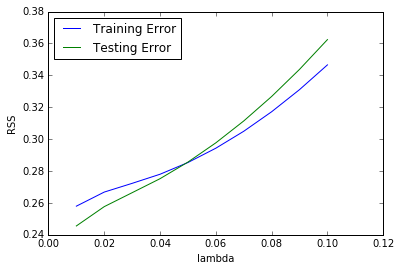

In [13]:
plt.plot(alphas,train_err,label = 'Training Error')
plt.plot(alphas,test_err,label='Testing Error')
plt.xlabel('lambda')
plt.ylabel('RSS')
plt.legend(loc='best')
plt.show()

In [14]:
terms = np.array(terms)
for coeff in coeffs:
    print terms[np.nonzero(coeff)[0]],\
        coeff[np.nonzero(coeff)[0]]    

['Z2' 'Z1' 'Z1Z4' 'Z1Z2'] [ 2.90305567 -1.66042743 -0.02240704 -0.21380964]
['Z2' 'Z1' 'Z1Z2'] [ 2.76961406 -1.7028102  -0.03034097]
['Z2' 'Z1'] [ 2.71291132 -1.67483906]
['Z2' 'Z1'] [ 2.67124466 -1.63483906]
['Z2' 'Z1'] [ 2.62957799 -1.59483906]
['Z2' 'Z1'] [ 2.58791132 -1.55483906]
['Z2' 'Z1'] [ 2.54624466 -1.51483906]
['Z2' 'Z1'] [ 2.50457799 -1.47483906]
['Z2' 'Z1'] [ 2.46291132 -1.43483906]
['Z2' 'Z1'] [ 2.42124466 -1.39483906]
